# Oracle of Assets

The oracle of assets is a tool for investors that identifies a subgroup of assets that minimize the risk to lose money. Using neutral atoms or in general a quantum computer, we can identify such a subgroup of assets using an algorithm known as Maximum Independent Set (MIS) and a quantum optimization algorithm. The subgroup of assets won't share a correlation between them, therefore if the price in the market of one of the assets decreases it won't affect the price of the others making an investment less risky. Our algorithm will ensure that the subgroup will have the greater variety of assets possible for an investor to invest in.

In [4]:
import networkx as nx
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Stocks Selection

We select 8 stocks from 8 conglomerates based on the work from Xu et al. [<b>[2]<i>](https://aclanthology.org/P18-1183/): 

- Basic Materials: TOTAL S.A. "TOT"

- Consumer Goods: Appel Inc. "AAPL"

- Healthcare: AbbVie Inc. "ABBV"

- Services: Wall-Mart Stores Inc. "WMT"

- Utilites: Duke energy corporation "DUK"

- Financial: HSBS Holding pcl "HSBC"

- Industrial Goods: ABB Ltd. "ABB"

- Technology: China Mobile Limited "CHL"

The information comes from Sep 2012 to Sep 2017 with daily Technical information of Open, High, Low, Close, Adj Close, and Volume for the stocks price.

In [5]:
stocks_name = ["AAPL","ABB", "ABBV","CHL", "DUK", "HSBC", "TOT", "WMT"]
n_stocks = len(stocks_name)
stocks_forecasting = {}
stocks_real = {}
kappa = {}
period_of_test = 90 # Days known the real price but not used during training
for name in stocks_name:
    stocks_real[name] = np.array(pd.read_csv(f"./Data/Stocks/{name}.csv")["Close"])[:1100]

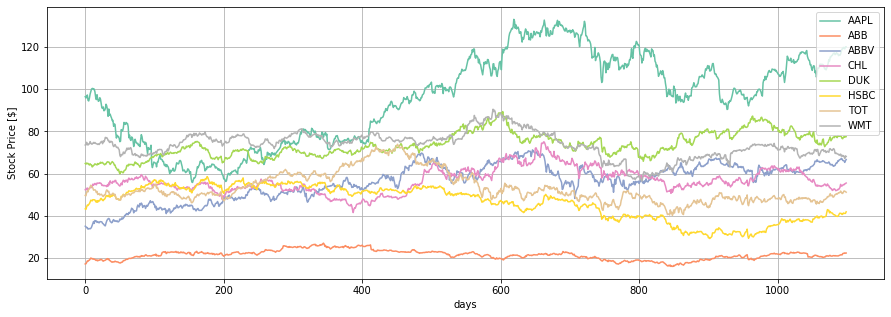

In [7]:
colors = plt.cm.get_cmap("Set2", n_stocks)
plt.figure(figsize=(15,5))
for i, name in enumerate(stocks_name):
    plt.plot(stocks_real[name], color=colors(i), label=stocks_name[i])
plt.xlabel("days")
plt.ylabel("Stock Price [$]")
plt.legend()
plt.grid()
plt.savefig("./Images/Stocks.png")

# Covariance Matrix

To know how strong is the correlation between two stocks, we use the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix). If the correlation between the two stocks exceeds a **threshold** during a period of time it means they are connected. We use a graph representation to show such a correlation as an edge between two nodes (the stocks). 

In [8]:
holding_period = 30 # Days of keeping the assets
data = [stocks_real[name] for name in stocks_name] #Stocks daily price
min_t = min([len(d) for d in data]) # The stocks have different number of recording days 
mu = []
for asset in range(n_stocks):
    mu.append([data[asset][t+1]/data[asset][t] - 1 if data[asset][t] != 0 else 1 for t in range(min_t-1)])
mu = np.array(mu)
split =  min_t // holding_period
covariance_matrix =  np.array([np.cov(mu[:,i*holding_period:(i+1)*holding_period], rowvar=True) for i in range(split)])


Text(0.5, 1.0, 'Covariance Matrix between stocks')

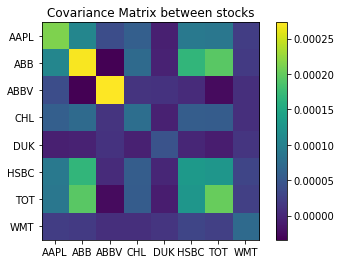

In [9]:
plt.figure()
plt.imshow(covariance_matrix[0])
plt.xticks(range(n_stocks), stocks_name)
plt.yticks(range(n_stocks), stocks_name)
plt.colorbar()
plt.title("Covariance Matrix between stocks")

In [10]:
threshold = 1e-05 #Threshold to include a correlation between stocks
connections = covariance_matrix[0] > threshold

In [11]:
G = nx.Graph()
G.add_nodes_from(range(n_stocks))
for i in range(n_stocks-1):
    for j in range(i+1, n_stocks):
        if connections[i,j]:
            G.add_edge(i,j)

In [12]:
labels = {i:stocks_name[i] for i in range(8)}

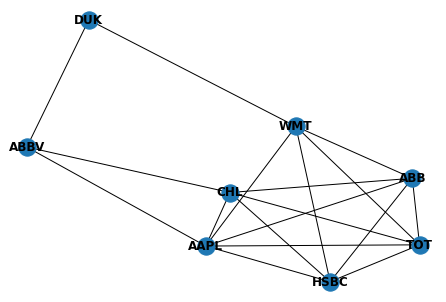

In [13]:
nx.draw(G, labels =labels, with_labels=True, font_weight='bold') # Graph of the connection between the stocks

# The solution

Now, We want to know which subset in this graph is the maximal independent set. This means, which subgroup of assets does not share the connection between them. This is important in portfolio optimization because we want to minimize the risk to lose money by the so call **"putting all the eggs in the same basket"**, if we have a diverse portfolio is hard we lose because one market is affected by some situation.

In this solution, we present the results using the Quantum Approximate Optimization algorithm ([QAOA](https://en.wikipedia.org/wiki/Quantum_optimization_algorithms)) and the Quadratic Unconstrained Binary Optimization ([QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization))on a gate-based quantum device.

To this end, Qiskit and its library of **qiskit_optimization** have all the tools needed to solve the MIS problem.

In [14]:
from qiskit_optimization.applications import StableSet
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CobylaOptimizer, CplexOptimizer 
from qiskit.providers.aer import QasmSimulator


In [15]:
model = StableSet(G)
qp = model.to_quadratic_program()
qubo = QuadraticProgramToQubo().convert(qp) # QUBO representation of the MIS problem for the 8 stocks.
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Stable set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 + [ 18 x_0*x_1
      + 18 x_0*x_2 + 18 x_0*x_3 + 18 x_0*x_5 + 18 x_0*x_6 + 18 x_0*x_7
      + 18 x_1*x_3 + 18 x_1*x_5 + 18 x_1*x_6 + 18 x_1*x_7 + 18 x_2*x_3
      + 18 x_2*x_4 + 18 x_3*x_5 + 18 x_3*x_6 + 18 x_4*x_7 + 18 x_5*x_6
      + 18 x_5*x_7 + 18 x_6*x_7 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7
End



In [47]:
reps = 3
optimizer = COBYLA(maxiter=50)
alpha = 0.5
intermediate_info = {'nfev': [],'parameters': [],'stddev': [],'mean': []}
    
def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    intermediate_info['stddev'].append(stddev)

qaoa_mes = QAOA(optimizer=optimizer, reps=reps, quantum_instance=QasmSimulator(), callback=callback)

In [48]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qubo)

In [49]:
intermediate_info['parameters'][0]

array([ 0.28664367, -5.54393808, -4.55349756, -5.53350174,  5.24093611,
       -2.67268555])

In [50]:
operator, offset = qubo.to_ising()

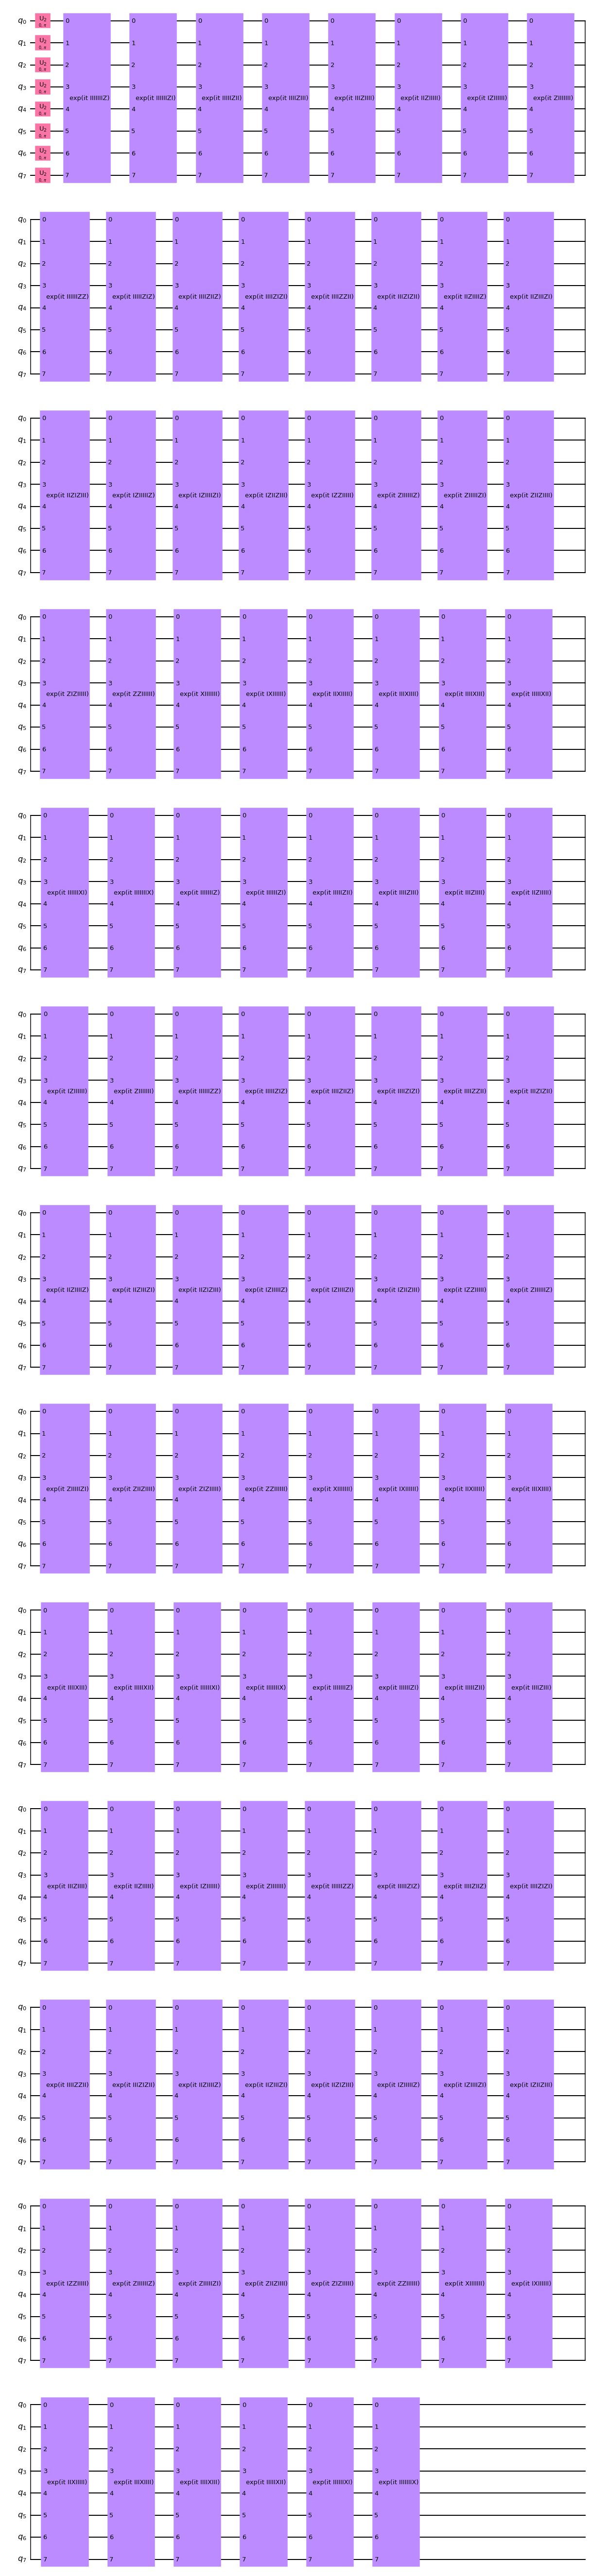

In [51]:
a = qaoa_mes.construct_circuit(intermediate_info['parameters'][0],operator)
a[0].decompose().draw("mpl")

In [52]:
print(result.prettyprint())

objective function value: -2.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0
status: SUCCESS


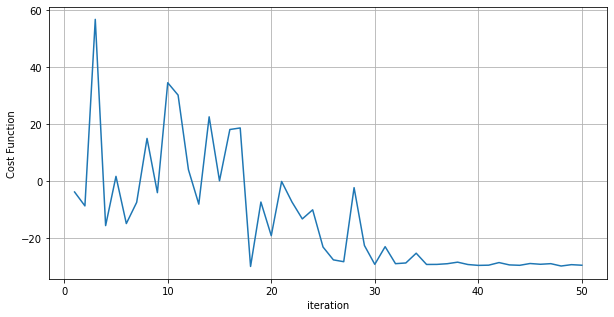

In [35]:
plt.figure(figsize=(10,5))
plt.plot(intermediate_info["nfev"], intermediate_info["mean"])
plt.xlabel("iteration")
plt.ylabel("Cost Function")
plt.grid()

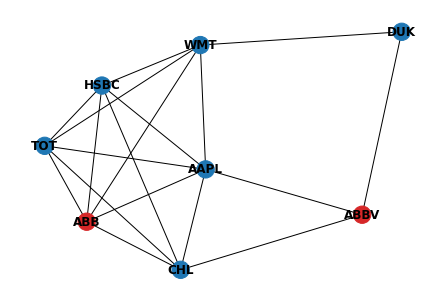

In [36]:
color_map = ["tab:blue" if i == 0 else "tab:red" for i in result.x]
nx.draw(G, labels =labels, with_labels=True, font_weight='bold',node_color=color_map) # Graph of the connection between the stocks

# Conclusion

Based on this small set, the suggestion for an investor is to pay special attention to AbbVie Inc. (ABBV) and ABB Ltd. (ABB) which are not correlated between them. 

# A bigger Dataset

Of course, it is a small example and its usefulness is not seen immediately, we repeated the same process for a fictitious case to prove the concept on a large scale.

In [37]:
n_stocks = 20
Oracle = nx.Graph()
Oracle.add_nodes_from(range(n_stocks))
for i in range(n_stocks - 1):
    for j in range(i+1, n_stocks):
        if np.random.rand() > 0.7: # There is a 30% probability of creating an edge between node i and j
            Oracle.add_edge(i, j)

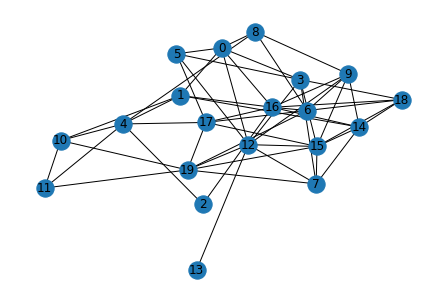

In [38]:
nx.draw(Oracle, with_labels=True)

In [39]:
model = StableSet(Oracle)
qp = model.to_quadratic_program()
qubo = QuadraticProgramToQubo().convert(qp) # QUBO representation of the MIS problem for the 8 stocks.
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Stable set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 - x_8 - x_9 - x_10 - x_11
      - x_12 - x_13 - x_14 - x_15 - x_16 - x_17 - x_18 - x_19 + [ 42 x_0*x_1
      + 42 x_0*x_3 + 42 x_0*x_5 + 42 x_0*x_8 + 42 x_0*x_12 + 42 x_0*x_16
      + 42 x_1*x_4 + 42 x_1*x_10 + 42 x_1*x_14 + 42 x_1*x_16 + 42 x_2*x_4
      + 42 x_2*x_16 + 42 x_3*x_5 + 42 x_3*x_7 + 42 x_3*x_12 + 42 x_3*x_15
      + 42 x_3*x_18 + 42 x_4*x_8 + 42 x_4*x_10 + 42 x_4*x_11 + 42 x_4*x_17
      + 42 x_5*x_12 + 42 x_5*x_17 + 42 x_6*x_8 + 42 x_6*x_9 + 42 x_6*x_16
      + 42 x_6*x_17 + 42 x_6*x_18 + 42 x_6*x_19 + 42 x_7*x_12 + 42 x_7*x_14
      + 42 x_7*x_15 + 42 x_7*x_19 + 42 x_8*x_9 + 42 x_9*x_12 + 42 x_9*x_14
      + 42 x_9*x_15 + 42 x_9*x_16 + 42 x_10*x_11 + 42 x_10*x_19 + 42 x_11*x_19
      + 42 x_12*x_13 + 42 x_12*x_15 + 42 x_12*x_19 + 42 x_14*x_15 + 42 x_14*x_16
      + 42 x_14*x_18 + 42 x_15*x_17 + 42 x_15*x_18 + 42 x_15*x

In [64]:
reps = 1
optimizer = COBYLA(maxiter=100)
alpha = 0.5
intermediate_info = {'nfev': [],'parameters': [],'stddev': [],'mean': []}
    
def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    intermediate_info['stddev'].append(stddev)

qaoa_mes = QAOA(optimizer=optimizer, reps=reps, quantum_instance=QasmSimulator(), callback=callback)

In [65]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qubo)

In [66]:
print(result.prettyprint())

objective function value: -6.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=0.0, x_9=0.0, x_10=0.0, x_11=1.0, x_12=0.0, x_13=1.0, x_14=0.0, x_15=0.0, x_16=0.0, x_17=0.0, x_18=0.0, x_19=0.0
status: SUCCESS


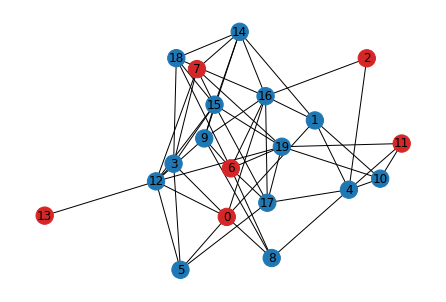

In [67]:
color_map = ["tab:blue" if i == 0 else "tab:red" for i in result.x]
nx.draw(Oracle, with_labels=True,node_color=color_map)

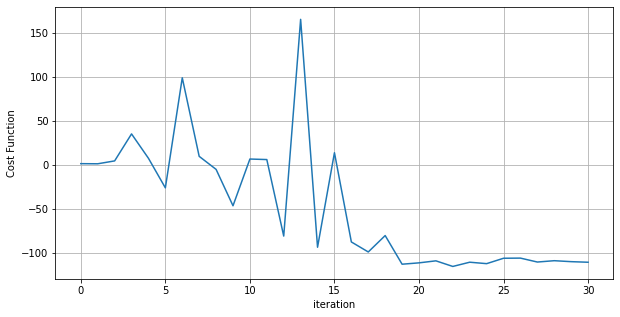

In [68]:
plt.figure(figsize=(10,5))
plt.plot(range(len(intermediate_info["mean"])), intermediate_info["mean"])
plt.xlabel("iteration")
plt.ylabel("Cost Function")
plt.grid()

# Classical Solution

Finally, we use cplex a classical optimizer to solve the same MIS problem. 

In [52]:
cplex_sol = CplexOptimizer().solve(qubo)
cplex_sol

<OptimizationResult: fval=-8.0, x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=0.0, x_9=1.0, x_10=0.0, x_11=1.0, x_12=0.0, x_13=1.0, x_14=0.0, x_15=0.0, x_16=0.0, x_17=1.0, x_18=1.0, x_19=0.0, status=SUCCESS>

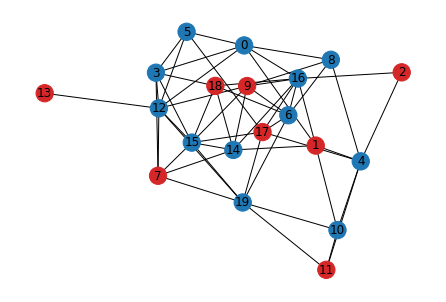

In [53]:
color_map = ["tab:blue" if i == 0 else "tab:red" for i in cplex_sol.x]
nx.draw(Oracle, with_labels=True,node_color=color_map)